In [1]:
!nvidia-smi

Wed Jun  1 20:18:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Download dummy dataset, load csv and split to train val - Upload kaggle key .json before
Change data format to class folder stucture train & val

In [5]:
#Upload kaggle api key in /content/

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir competitionKaggle
! pip install --upgrade --force-reinstall --no-deps kaggle

#https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images
!kaggle datasets download -p /content/competitionKaggle/ -d benjaminwarner/resized-2015-2019-blindness-detection-images

!unzip /content/competitionKaggle/resized-2015-2019-blindness-detection-images.zip -d /content/competitionKaggle/
!rm /content/competitionKaggle/resized-2015-2019-blindness-detection-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/competitionKaggle/resized train 15/8514_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8514_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8515_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8515_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8517_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8517_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8519_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8519_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/851_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/851_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8522_left.jpg  
  inflating: /content/competitionKaggle/resized train 15/8522_right.jpg  
  inflating: /content/competitionKaggle/resized train 15/8526_left.jp

In [6]:
import pandas as pd

train = pd.read_csv("/content/competitionKaggle/labels/trainLabels15.csv")#"/content/competitionKaggle/trainLabels.csv")#"../input/com3025-2022-image-classification-challenge/train.csv"
train = train.astype('string')

test = pd.read_csv("/content/competitionKaggle/labels/testLabels15.csv")#"/content/competitionKaggle/trainLabels.csv")#"../input/com3025-2022-image-classification-challenge/train.csv"
test = test.astype('string')

train2 = pd.read_csv("/content/competitionKaggle/labels/trainLabels19.csv")#"/content/competitionKaggle/trainLabels.csv")#"../input/com3025-2022-image-classification-challenge/train.csv"
train2 = train2.astype('string')


def append_ext(fn):#add file extention to filenames
    return fn+".jpg"#".jpeg"#check converted file extention

train["image"]=train["image"].apply(append_ext)

test["image"]=test["image"].apply(append_ext)

train2["id_code"]=train2["id_code"].apply(append_ext)

#SAMPLE SMALLER FOR QUICK RUNS --------------------------------------------------------------------------------------------------------------------------------------------
#and making demo dataset
# train = train.sample(1000)
# test = test.sample(1000)
# train2 = train2.sample(1000)

Convert data from directories with all images into train/{classnumber}/ folder structure

In [7]:
!mkdir /content/competitionKaggle/train
!mkdir /content/competitionKaggle/val

In [8]:
#very quick
import os
import shutil

def createFolderTreeFromDataframe(df, folder, source, ycolumn, imageCol):
  for index, row in df.iterrows():#for every row
    image_class = row[ycolumn]#load the class
    if not os.path.exists(f'/content/competitionKaggle/{folder}/{image_class}'):#create class folder if it doesnt exist
      os.makedirs(f'/content/competitionKaggle/{folder}/{image_class}')
    image_name = row[imageCol]#load the filename
    shutil.move(f"/content/competitionKaggle/{source}/{image_name}", f"/content/competitionKaggle/{folder}/{image_class}/")#move that file to the new dest

createFolderTreeFromDataframe(train, "train", "resized train 15",'level', 'image')
createFolderTreeFromDataframe(test, "train", "resized test 15",'level', 'image')#put test in train as well
createFolderTreeFromDataframe(train2, "train", "resized train 19", 'diagnosis', 'id_code')#put test in train as well
#92364 total images

# createFolderTreeFromDataframe(test, "val", "resized test 15")

If needed split into val with 20 of the images

In [9]:
#----------------------put 20% of images in val
import os
import random
random.seed(0)

for i in range(5):
  files = os.listdir(f"/content/competitionKaggle/train/{i}")
  random.shuffle(files)
  files = files[:int(len(files)*0.2)]
  for fileName in files:
    if not os.path.exists(f'/content/competitionKaggle/val/{i}'):#create class folder if it doesnt exist
      os.makedirs(f'/content/competitionKaggle/val/{i}')
    shutil.move(f"/content/competitionKaggle/train/{i}/{fileName}", f"/content/competitionKaggle/val/{i}/")#move that file to the new dest

##make demo datset with val split or full train without train

In [10]:
#move val and train to new dataset folder
# !mkdir /content/competitionKaggle/demodataset
# !mv /content/competitionKaggle/train /content/competitionKaggle/demodataset
# !mv /content/competitionKaggle/val /content/competitionKaggle/demodataset

In [11]:
# #making demo dataset - delete after and not run again
# !kaggle datasets init -p /content/competitionKaggle/demodataset
# #change json metadata

In [12]:
# !kaggle datasets create -p /content/competitionKaggle/demodataset/ --dir-mode zip

#Swin Supervised

## SWIN SUPERVISED SETUP

In [13]:
%cd /content

#Go back to the start

/content


In [16]:
!git clone https://github.com/microsoft/Swin-Transformer.git
%cd /content/Swin-Transformer
!git reset --hard cbaa0d8707db403d85ad0e13c59f2f71cd6db425

#checkout commit before further changes

fatal: destination path 'Swin-Transformer' already exists and is not an empty directory.
/content/Swin-Transformer
HEAD is now at cbaa0d8 Update README.md (#187)


In [17]:
#not sure on location
%cd /content/Swin-Transformer
!pip3 install install pytorch==1.7.1 torchvision==0.8.2 cudatoolkit==10.1

/content/Swin-Transformer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pytorch==1.7.1 (from versions: 0.1.2, 1.0.2)
ERROR: No matching distribution found for pytorch==1.7.1


In [18]:
#Install from VISSL notebook

# Install pytorch version 1.8
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install Apex by checking system settings: cuda version, pytorch version, and python version
import sys
import torch
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{torch.__version__[0:5:2]}"
])
print(version_str)

# install apex (pre-compiled with optimizer C++ extensions and CUDA kernels)
!pip install apex -f https://dl.fbaipublicfiles.com/vissl/packaging/apexwheels/{version_str}/download.html

import torch
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

!nvcc --version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 15 kB/s 
     |████████████████████████████████| 17.3 MB 435 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0+cu101 which

In [19]:
%cd /content/Swin-Transformer
!pip install opencv-python==4.4.0.46 termcolor==1.1.0 yacs==0.1.8 diffdist

# !pip install timm==0.3.2
!pip install timm==0.4.9
!pip install PyYaml==5.1

/content/Swin-Transformer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.5 MB 85 kB/s 
  Created wheel for diffdist: filename=diffdist-0.1-py3-none-any.whl size=6553 sha256=5895076a6bfc4f9229c555b73ab60005a579e19eba116a32d2d208490437cb0a
  Stored in directory: /root/.cache/pip/wheels/58/eb/5d/4878c7186753c09afacb2a43a74b45289488ebc62e9576565e
Successfully built diffdist
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

## SWIN RUN

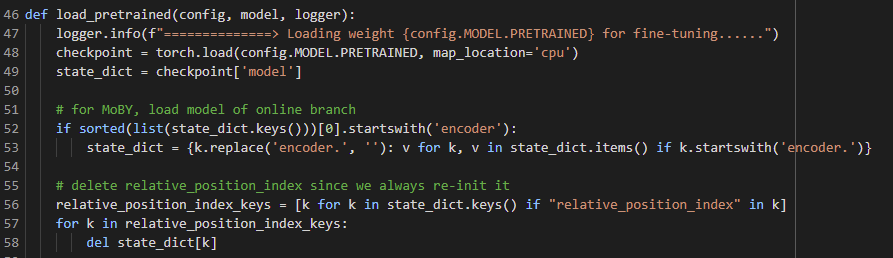

Get pretrained models


In [20]:
#download models
!kaggle datasets download -d gilescodes/models

!unzip /content/Swin-Transformer/models.zip
!rm /content/Swin-Transformer/models.zip

100% 1.86G/1.87G [00:35<00:00, 66.5MB/s]
100% 1.87G/1.87G [00:35<00:00, 57.0MB/s]
Archive:  /content/Swin-Transformer/models.zip
  inflating: ckpt_244px_epoch_165.pth  
  inflating: ckpt_488px_epoch_1.pth  
  inflating: ckpt_672px_epoch_40 (bugged).pth  
  inflating: ckpt_672px_epoch_45.pth  


In [22]:
%cd /content/Swin-Transformer

#or use --opts flag
batch_size = 64
image_size = 224*1 #*2 #*3 #*4
TRAIN_EPOCHS = 100
TRAIN_WARMUP_EPOCHS = 1
NUM_CLASSES = 5
SAVE_FREQ = 5


!python -m torch.distributed.launch --nproc_per_node 1 --master_port 12345  "/content/Swin-Transformer/main.py" \
--cfg configs/swin_tiny_patch4_window7_224.yaml --pretrained "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224.pth" \
--data-path '/content/competitionKaggle/' --batch-size $batch_size  \
--output '/content/drive/MyDrive/Colab Notebooks/FYP/Final Code/' \
--opts TRAIN.EPOCHS $TRAIN_EPOCHS TRAIN.WARMUP_EPOCHS $TRAIN_WARMUP_EPOCHS MODEL.NUM_CLASSES $NUM_CLASSES DATA.IMG_SIZE $image_size \
SAVE_FREQ $SAVE_FREQ \
--tag "Test" \
# --use-checkpoint

#"/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224.pth" - their
#"/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/moby_swin_t_300ep_pretrained.pth" - moby pretrained
#"/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/moby__swin_tiny__patch4_window7_224__odpr02_tdpr0_cm099_ct02_queue4096_proj2_pred2/default/ckpt_epoch_0.pth"

/content/Swin-Transformer
=> merge config from configs/swin_tiny_patch4_window7_224.yaml
RANK and WORLD_SIZE in environ: 0/1
[2022-06-01 20:36:31 swin_tiny_patch4_window7_224](main.py 352): INFO Full config saved to /content/drive/MyDrive/Colab Notebooks/FYP/Final Code/swin_tiny_patch4_window7_224/Test/config.json
[2022-06-01 20:36:31 swin_tiny_patch4_window7_224](main.py 355): INFO AMP_OPT_LEVEL: O1
AUG:
  AUTO_AUGMENT: rand-m9-mstd0.5-inc1
  COLOR_JITTER: 0.4
  CUTMIX: 1.0
  CUTMIX_MINMAX: null
  MIXUP: 0.8
  MIXUP_MODE: batch
  MIXUP_PROB: 1.0
  MIXUP_SWITCH_PROB: 0.5
  RECOUNT: 1
  REMODE: pixel
  REPROB: 0.25
BASE:
- ''
DATA:
  BATCH_SIZE: 64
  CACHE_MODE: part
  DATASET: imagenet
  DATA_PATH: /content/competitionKaggle/
  IMG_SIZE: 224
  INTERPOLATION: bicubic
  NUM_WORKERS: 8
  PIN_MEMORY: true
  ZIP_MODE: false
EVAL_MODE: false
LOCAL_RANK: 0
MODEL:
  DROP_PATH_RATE: 0.2
  DROP_RATE: 0.0
  LABEL_SMOOTHING: 0.1
  NAME: swin_tiny_patch4_window7_224
  NUM_CLASSES: 5
  PRETRAINED: /

Train and eval DR models with diff inits

In [15]:
%cd /content/Swin-Transformer
#ImageNet supervised pretrained 224
batch_size = 128#less to fit in vram
image_size = 224*1 #*2 #*3 #*4
TRAIN_EPOCHS = 50
TRAIN_WARMUP_EPOCHS = 1
NUM_CLASSES = 5
SWIN_WINDOW_SIZE=7*1# 7,14,21
SAVE_FREQ = 5

!python -m torch.distributed.launch --nproc_per_node 1 --master_port 12345  "/content/Swin-Transformer/main.py" \
--cfg configs/swin_tiny_patch4_window7_224.yaml --pretrained "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224.pth" \
--data-path '/content/competitionKaggle/' --batch-size $batch_size  \
--output '/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/' \
--opts TRAIN.EPOCHS $TRAIN_EPOCHS TRAIN.WARMUP_EPOCHS $TRAIN_WARMUP_EPOCHS MODEL.NUM_CLASSES $NUM_CLASSES DATA.IMG_SIZE $image_size \
SAVE_FREQ $SAVE_FREQ \
MODEL.SWIN.WINDOW_SIZE $SWIN_WINDOW_SIZE --tag "ImageNetSupervisedPretrained224"

/content/Swin-Transformer
=> merge config from configs/swin/swin_tiny_patch4_window7_224.yaml
RANK and WORLD_SIZE in environ: 0/1
[2022-06-01 20:05:35 swin_tiny_patch4_window7_224](main.py 334): INFO Full config saved to /content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/ImageNetSupervisedPretrained224/config.json
[2022-06-01 20:05:35 swin_tiny_patch4_window7_224](main.py 337): INFO AMP_ENABLE: true
AMP_OPT_LEVEL: ''
AUG:
  AUTO_AUGMENT: rand-m9-mstd0.5-inc1
  COLOR_JITTER: 0.4
  CUTMIX: 1.0
  CUTMIX_MINMAX: null
  MIXUP: 0.8
  MIXUP_MODE: batch
  MIXUP_PROB: 1.0
  MIXUP_SWITCH_PROB: 0.5
  RECOUNT: 1
  REMODE: pixel
  REPROB: 0.25
BASE:
- ''
DATA:
  BATCH_SIZE: 128
  CACHE_MODE: part
  DATASET: imagenet
  DATA_PATH: /content/competitionKaggle/
  IMG_SIZE: 224
  INTERPOLATION: bicubic
  NUM_WORKERS: 8
  PIN_MEMORY: true
  ZIP_MODE: false
EVAL_MODE: false
LOCAL_RANK: 0
MODEL:
  DROP_PATH_RATE: 0.2
  DROP_RATE: 0.0
  LABEL_SMOOTHING: 0.1
  NAME: swin_tin

In [ ]:
%cd /content/Swin-Transformer
#Random init
batch_size = 128#less to fit in vram
image_size = 224*1 #*2 #*3 #*4
TRAIN_EPOCHS = 50
TRAIN_WARMUP_EPOCHS = 1
NUM_CLASSES = 5
SWIN_WINDOW_SIZE=7*1# 7,14,21
SAVE_FREQ = 5

!python -m torch.distributed.launch --nproc_per_node 1 --master_port 12345  "/content/Swin-Transformer/main.py" \
--cfg configs/swin_tiny_patch4_window7_224.yaml \
--data-path '/content/competitionKaggle/' --batch-size $batch_size  \
--output '/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/' \
--opts TRAIN.EPOCHS $TRAIN_EPOCHS TRAIN.WARMUP_EPOCHS $TRAIN_WARMUP_EPOCHS MODEL.NUM_CLASSES $NUM_CLASSES DATA.IMG_SIZE $image_size \
SAVE_FREQ $SAVE_FREQ \
MODEL.SWIN.WINDOW_SIZE $SWIN_WINDOW_SIZE --tag "RandomInit224"

=> merge config from configs/swin_tiny_patch4_window7_224.yaml
RANK and WORLD_SIZE in environ: 0/1
[2022-05-07 09:43:28 swin_tiny_patch4_window7_224](main.py 352): INFO Full config saved to /content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/swin_tiny_patch4_window7_224/RandomInit224/config.json
[2022-05-07 09:43:29 swin_tiny_patch4_window7_224](main.py 355): INFO AMP_OPT_LEVEL: O1
AUG:
  AUTO_AUGMENT: rand-m9-mstd0.5-inc1
  COLOR_JITTER: 0.4
  CUTMIX: 1.0
  CUTMIX_MINMAX: null
  MIXUP: 0.8
  MIXUP_MODE: batch
  MIXUP_PROB: 1.0
  MIXUP_SWITCH_PROB: 0.5
  RECOUNT: 1
  REMODE: pixel
  REPROB: 0.25
BASE:
- ''
DATA:
  BATCH_SIZE: 128
  CACHE_MODE: part
  DATASET: imagenet
  DATA_PATH: /content/competitionKaggle/
  IMG_SIZE: 224
  INTERPOLATION: bicubic
  NUM_WORKERS: 8
  PIN_MEMORY: true
  ZIP_MODE: false
EVAL_MODE: false
LOCAL_RANK: 0
MODEL:
  DROP_PATH_RATE: 0.2
  DROP_RATE: 0.0
  LABEL_SMOOTHING: 0.1
  NAME: swin_tiny_patch4_window7_224
  NUM_CLASSES: 5
  PRETRAINED: ''
  RESUME: '

Change the utils to allow for moby model loading from pretrained

dont need when resuming

Try the moby model for 244px

https://github.com/Giles-Billenness/Swin-Transformer/commit/8768b6b15ef3b873dba948e809b9876dd46b3795

In [ ]:
%cd /content/Swin-Transformer
#imagenet unsupervised pretrained
batch_size = 128#less to fit in vram
image_size = 224*1 #*2 #*3 #*4
TRAIN_EPOCHS = 50
TRAIN_WARMUP_EPOCHS = 1
NUM_CLASSES = 5
SWIN_WINDOW_SIZE=7*1# 7,14,21
SAVE_FREQ = 5

!python -m torch.distributed.launch --nproc_per_node 1 --master_port 12345  "/content/Swin-Transformer/main.py" \
--cfg configs/swin_tiny_patch4_window7_224.yaml --pretrained "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/moby_swin_t_300ep_pretrained.pth" \
--data-path '/content/competitionKaggle/' --batch-size $batch_size  \
--output '/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/' \
--opts TRAIN.EPOCHS $TRAIN_EPOCHS TRAIN.WARMUP_EPOCHS $TRAIN_WARMUP_EPOCHS MODEL.NUM_CLASSES $NUM_CLASSES DATA.IMG_SIZE $image_size \
SAVE_FREQ $SAVE_FREQ \
MODEL.SWIN.WINDOW_SIZE $SWIN_WINDOW_SIZE --tag "ImageNetUnsupervisedPretrainMOBY224"

Streaming output truncated to the last 5000 lines.
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop): Dropout(p=0.0, inplace=False)
          )
        )
        (1): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=3, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0

In [ ]:
%cd /content/Swin-Transformer/
#mine moby 224
batch_size = 128#less to fit in vram
image_size = 224*1 #*2 #*3 #*4
TRAIN_EPOCHS = 150
TRAIN_WARMUP_EPOCHS = 1
NUM_CLASSES = 5
SWIN_WINDOW_SIZE=7*1# 7,14,21
SAVE_FREQ = 5

!python -m torch.distributed.launch --nproc_per_node 1 --master_port 12345  "/content/Swin-Transformer/main.py" \
--cfg "/content/Swin-Transformer/configs/swin_tiny_patch4_window7_224.yaml" --pretrained "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/SwinMoBYMine224ckpt_epoch_180.pth" \
--data-path '/content/competitionKaggle/' --batch-size $batch_size  \
--output '/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/' \
--opts TRAIN.EPOCHS $TRAIN_EPOCHS TRAIN.WARMUP_EPOCHS $TRAIN_WARMUP_EPOCHS MODEL.NUM_CLASSES $NUM_CLASSES DATA.IMG_SIZE $image_size \
SAVE_FREQ $SAVE_FREQ \
--tag "MineUnsupervisedPretrainMOBY224" \

Streaming output truncated to the last 5000 lines.
[2022-05-16 08:03:33 swin_tiny_patch4_window7_224](main.py 209): INFO Train: [85/150][340/577]	eta 0:02:37 lr 0.000050	 wd 0.0500	time 0.4604 (0.6633)	loss 1.6995 (1.8087)	grad_norm 1.3425 (inf)	loss_scale 65536.0000 (70725.0674)	mem 11807MB
[2022-05-16 08:03:39 swin_tiny_patch4_window7_224](main.py 209): INFO Train: [85/150][350/577]	eta 0:02:30 lr 0.000049	 wd 0.0500	time 0.4511 (0.6628)	loss 1.9127 (1.8097)	grad_norm 1.2914 (inf)	loss_scale 65536.0000 (70577.2308)	mem 11807MB
[2022-05-16 08:03:46 swin_tiny_patch4_window7_224](main.py 209): INFO Train: [85/150][360/577]	eta 0:02:23 lr 0.000049	 wd 0.0500	time 1.1213 (0.6632)	loss 1.6661 (1.8095)	grad_norm 1.9041 (inf)	loss_scale 65536.0000 (70437.5845)	mem 11807MB
[2022-05-16 08:03:53 swin_tiny_patch4_window7_224](main.py 209): INFO Train: [85/150][370/577]	eta 0:02:17 lr 0.000049	 wd 0.0500	time 0.4806 (0.6652)	loss 1.8023 (1.8100)	grad_norm 0.6873 (inf)	loss_scale 65536.0000 (70305

Larger image models

In [ ]:
%cd /content/Swin-Transformer
#mine moby 488px 
#or use --opts flag
batch_size = 16#less to fit in vram
image_size = 224*2 #*2 #*3 #*4
TRAIN_EPOCHS = 20
TRAIN_WARMUP_EPOCHS = 1
NUM_CLASSES = 5
SWIN_WINDOW_SIZE=7*2# 7,14,21

!python -m torch.distributed.launch --nproc_per_node 1 --master_port 12345  "/content/Swin-Transformer/main.py" \
--cfg "/content/Swin-Transformer/configs/swin_tiny_patch4_window7_224.yaml" --pretrained "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/SwinMoBYMine448ckpt_epoch_0.pth" \
--data-path '/content/competitionKaggle/' --batch-size $batch_size  \
--output '/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/' \
--opts TRAIN.EPOCHS $TRAIN_EPOCHS TRAIN.WARMUP_EPOCHS $TRAIN_WARMUP_EPOCHS MODEL.NUM_CLASSES $NUM_CLASSES DATA.IMG_SIZE $image_size \
MODEL.SWIN.WINDOW_SIZE $SWIN_WINDOW_SIZE --tag "MineUnsupervisedPretrainMOBY448"

Streaming output truncated to the last 5000 lines.
[2022-05-17 03:51:44 swin_tiny_patch4_window7_224](main.py 209): INFO Train: [11/20][2570/4618]	eta 0:17:01 lr 0.000006	 wd 0.0500	time 0.5546 (0.4988)	loss 1.9854 (1.6970)	grad_norm 5.7952 (inf)	loss_scale 32768.0000 (35368.0280)	mem 10235MB
[2022-05-17 03:51:49 swin_tiny_patch4_window7_224](main.py 209): INFO Train: [11/20][2580/4618]	eta 0:16:56 lr 0.000006	 wd 0.0500	time 0.5534 (0.4987)	loss 1.7358 (1.6968)	grad_norm 3.1065 (inf)	loss_scale 32768.0000 (35357.9543)	mem 10235MB
[2022-05-17 03:51:54 swin_tiny_patch4_window7_224](main.py 209): INFO Train: [11/20][2590/4618]	eta 0:16:51 lr 0.000006	 wd 0.0500	time 0.5231 (0.4988)	loss 2.4288 (1.6969)	grad_norm 6.5746 (inf)	loss_scale 32768.0000 (35347.9583)	mem 10235MB
[2022-05-17 03:51:59 swin_tiny_patch4_window7_224](main.py 209): INFO Train: [11/20][2600/4618]	eta 0:16:46 lr 0.000006	 wd 0.0500	time 0.5190 (0.4988)	loss 2.2177 (1.6975)	grad_norm 8.0622 (inf)	loss_scale 32768.0000 (3

In [ ]:
%cd /content/Swin-Transformer
#mine moby 672px
#or use --opts flag
batch_size = 4
image_size = 224*3 #*2 #*3 #*4
TRAIN_EPOCHS = 12
TRAIN_WARMUP_EPOCHS = 1
NUM_CLASSES = 5
SWIN_WINDOW_SIZE=7*3# 7,14,21

!python -m torch.distributed.launch --nproc_per_node 1 --master_port 12345  "/content/Swin-Transformer/main.py" \
--cfg "/content/Swin-Transformer/configs/swin_tiny_patch4_window7_224.yaml" --pretrained "/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/SwinMoBYMine672ckpt_epoch_40.pth" \
--data-path '/content/competitionKaggle/' --batch-size $batch_size  \
--output '/content/drive/MyDrive/Colab Notebooks/FYP/MOBY SSL SWIN/' \
--opts TRAIN.EPOCHS $TRAIN_EPOCHS TRAIN.WARMUP_EPOCHS $TRAIN_WARMUP_EPOCHS MODEL.NUM_CLASSES $NUM_CLASSES DATA.IMG_SIZE $image_size \
MODEL.SWIN.WINDOW_SIZE $SWIN_WINDOW_SIZE --tag "MineUnsupervisedPretrainMOBY672"

Streaming output truncated to the last 5000 lines.
[2022-05-18 01:17:42 swin_tiny_patch4_window7_224](main.py 258): INFO Test: [2950/4618]	Time 0.084 (0.162)	Loss 0.1769 (0.2368)	Acc@1 100.000 (98.390)	Acc@5 100.000 (100.000)	Mem 9957MB
[2022-05-18 01:17:44 swin_tiny_patch4_window7_224](main.py 258): INFO Test: [2960/4618]	Time 0.089 (0.161)	Loss 0.4707 (0.2369)	Acc@1 75.000 (98.387)	Acc@5 100.000 (100.000)	Mem 9957MB
[2022-05-18 01:17:45 swin_tiny_patch4_window7_224](main.py 258): INFO Test: [2970/4618]	Time 0.135 (0.161)	Loss 0.1974 (0.2368)	Acc@1 100.000 (98.393)	Acc@5 100.000 (100.000)	Mem 9957MB
[2022-05-18 01:17:47 swin_tiny_patch4_window7_224](main.py 258): INFO Test: [2980/4618]	Time 0.240 (0.161)	Loss 0.4172 (0.2369)	Acc@1 75.000 (98.381)	Acc@5 100.000 (100.000)	Mem 9957MB
[2022-05-18 01:17:48 swin_tiny_patch4_window7_224](main.py 258): INFO Test: [2990/4618]	Time 0.092 (0.161)	Loss 0.2825 (0.2368)	Acc@1 100.000 (98.387)	Acc@5 100.000 (100.000)	Mem 9957MB
[2022-05-18 01:17:50 